In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch
import torchvision
import cv2

from tqdm.notebook import tqdm

In [ ]:
from functools import partial

In [ ]:
from torch import nn

In [ ]:
device = 'cpu'

In [ ]:
import mzr
from mzr import *

torch.Size([10, 1, 105, 80]) torch.Size([10]) torch.Size([10]) None


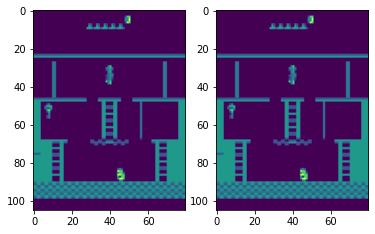

In [ ]:
env = mzr.MZRevenge()
snap, obs, reward, done, info = env.reset()
for i in range(2):
    snap, obs, reward, done, info = env.step(1+torch.zeros(10).long())
print(obs.shape, reward.shape, done.shape, info)
plt.subplot(121)
plt.imshow(obs[0, 0].numpy())

env = mzr.MZRevenge()
snap, obs, reward, done, info = env.reset(snap)
plt.subplot(122)
plt.imshow(obs[0, 0].numpy())

In [ ]:
env = gym.make('MontezumaRevengeDeterministic-v4', render_mode='rgb_array')
env = gym.wrappers.ResizeObservation(env, (21*5, 16*5))
env = gym.wrappers.GrayScaleObservation(env)
env.reset();
a = env.step(0)
len(a)

5

In [87]:
args = mzr.parser.parse_args('--device cpu --n_steps 10'.split())
data = mzr.run(args)

100%|██████████| 10/10 [00:01<00:00,  5.87it/s, n_nodes=1001, n_cells=228, n_dead=133, n_seen_max=133]


In [88]:
ge = data['ge']
env = data['env']

In [ ]:
cells = list(ge.cell2n_seen.keys())
n_seen = torch.tensor([ge.cell2n_seen[cell] for cell in cells])
cells = [cells[i] for i in n_seen.argsort()]
n_seen = n_seen.sort().values

o = torch.stack([ge.cell2node[cell].obs for cell in cells])
print(o.numel(), o.shape)
# o = torch.stack([node.obs for node in ge])
# print(o.numel(), o.shape)

2612400 torch.Size([311, 1, 105, 80])


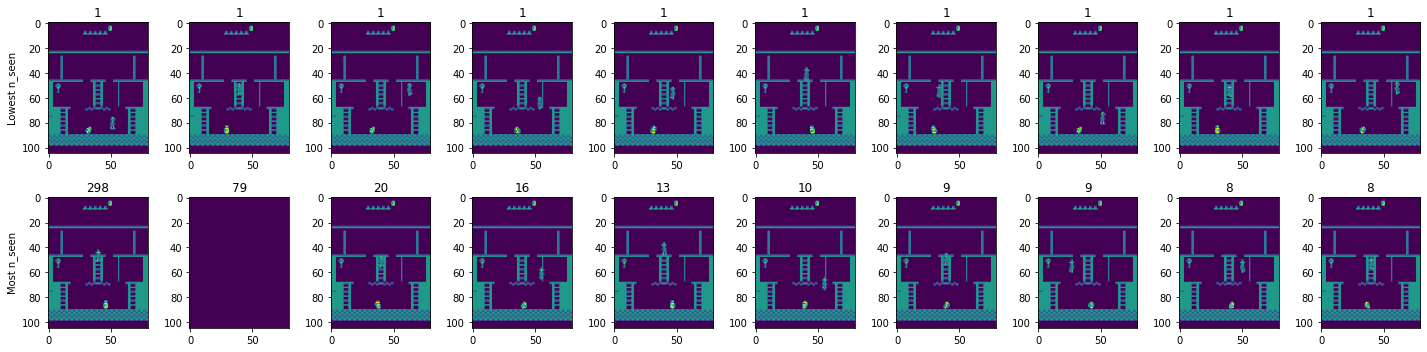

In [ ]:
n_ex = 10
fig, axs = plt.subplots(2, n_ex, figsize=(2*n_ex, 2.5*2))
for i in range(n_ex):
    axs[0, i].imshow(o[i, 0].numpy())
    axs[1, i].imshow(o[-1-i, 0].numpy())
    axs[0, i].set_title(f'{n_seen[i]}')
    axs[1, i].set_title(f'{n_seen[-1-i]}')
axs[0, 0].set_ylabel('Lowest n_seen')
axs[1, 0].set_ylabel('Most n_seen')
plt.tight_layout()
plt.show()
# plt.imshow(ge.cell2node[cells[-2]].obs[0].numpy())

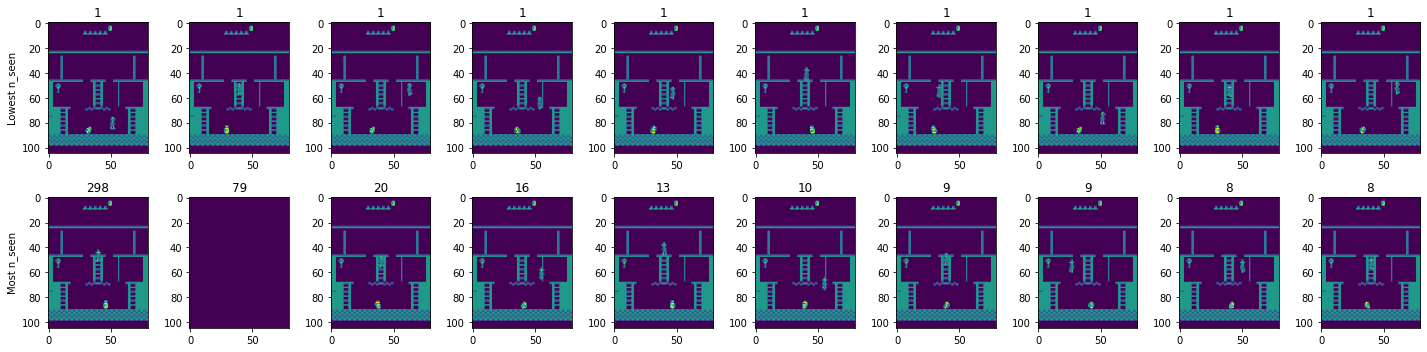

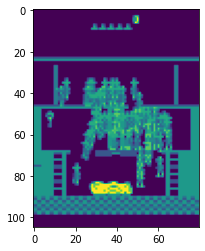

In [ ]:

viz_ge_outliers(ge)
plt.show()
plot_ge_outlier_coverage(ge)
plt.show()

torch.Size([105, 80])


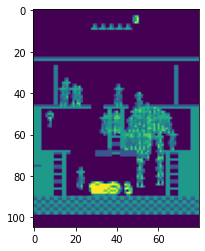

In [ ]:
a = o[:50].max(dim=0).values.sum(dim=0)
print(a.shape)
plt.imshow(a.numpy())

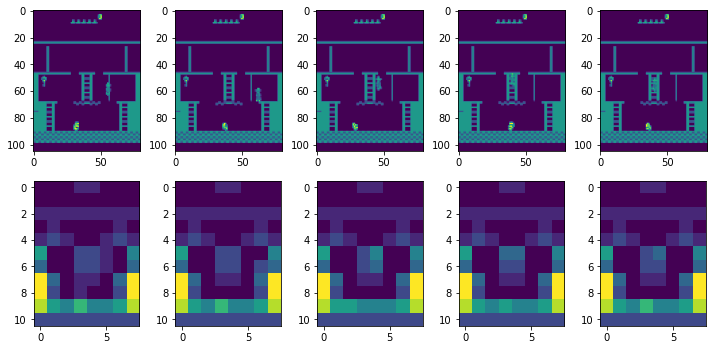

In [119]:

ex = mzr.ImitationExplorer(env)
viz_ge_outliers(ge, ex, n_ex=5)

In [ ]:
def calc_reward_novelty(ge, log=True):
    """
    Calculates a reward using n_seen
    """
    n_seen = torch.tensor([ge.cell2n_seen[node.latent] for node in tqdm(ge)]).float()
    return -n_seen.log() if log else -n_seen

ex = mzr.ImitationExplorer(env)
opt = torch.optim.Adam(ex.parameters(), lr=1e-2)

obs = torch.stack([trans[1] for node in ge for trans in node.traj])
action = torch.stack([trans[2] for node in ge for trans in node.traj])
mask_done = torch.stack([trans[4] for node in ge for trans in node.traj])
reward = calc_reward_novelty(ge)
# reward = torch.stack([reward[i] for i, node in enumerate(ge) for trans in node.traj])
# reward = (reward-reward[~mask_done].mean())/(reward[~mask_done].std()+1e-9)
print(obs.shape, action.shape, mask_done.shape, reward.shape)

# bc.train_contrastive_bc(explorer, opt, obs, action, reward,
#                         args.n_updates_learn, args.batch_size, 
#                         args.coef_entropy, args.device, data, viz=False)

100%|██████████| 1001/1001 [00:00<00:00, 6438.25it/s]

torch.Size([1000, 1, 105, 80]) torch.Size([1000]) torch.Size([1000]) torch.Size([1001])


In [ ]:
r_ori = torch.stack([reward[i] for i, node in enumerate(ge) for trans in node.traj])

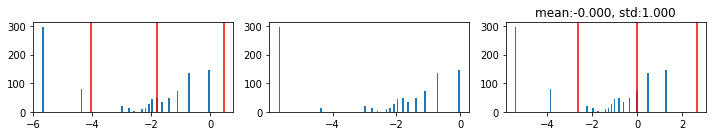

In [ ]:

def normalize_robust(x, mask_done, robust_devs=1, viz=True):
    y = x[~mask_done]
    if robust_devs is not None:
        mask_robust = ((y-y.median())/(y.std()+1e-9)).abs() < robust_devs
        z = y[mask_robust]
        out = (x-z.mean())/(z.std()+1e-9)
    else:
        out = (x-y.mean())/(y.std()+1e-9)
    if viz:
        plt.figure(figsize=(10, 2))
        plt.subplot(131)
        plt.hist(x.numpy(), bins=100)
        for i in [-1, 0, 1]:
            plt.axvline(y.median().item()+i*y.std().item()*robust_devs, c='r')
        plt.subplot(132)
        plt.hist(y.numpy(), bins=100)
        plt.subplot(133)
        plt.hist(out.numpy(), bins=100)
        a = out[out.abs()<out.std()]
        print()
        for i in [-1, 0, 1]:
            plt.axvline(i*out.std().item(), c='r')
        plt.title(f'mean:{a.mean():.3f}, std:{a.std():.3f}')
        plt.tight_layout()
        return out, plt.gcf()
    return out, None

r, fig = normalize_robust(r_ori, mask_done, viz=True)

In [ ]:
reward.mean()

tensor(-2.7326)

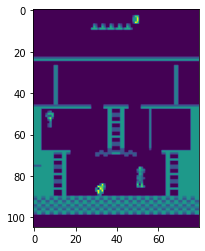

In [ ]:
plt.imshow(ge.cell2node[cells[-0]].obs[0].numpy())

In [ ]:
torch.as_tensor([(1,1), (2,2)])

tensor([[1, 1],
        [2, 2]])

In [ ]:
env = mzr.MZRevenge(n_envs=10)

KeyboardInterrupt: 

In [ ]:
snapshot, obs, reward, done, info = env.reset()

In [ ]:
snapshot, obs, reward, done, info = env.step(torch.zeros(10).long())

In [ ]:
done

tensor([False, False, False, False, False, False, False, False, False, False])

In [ ]:
# gym.wrappers.frame_stack.FrameStack(env, 4)

In [ ]:
import gym

In [ ]:
env = gym.make('MontezumaRevengeDeterministic-v4')
obs = env.reset()
# obs = torch.from_numpy(obs)

In [ ]:
def to_latent(snapshot, obs, h=11, w=8, d=20, return_tuple=False):
    obs, _, _, _, _ = snapshot
    # obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    obs = cv2.resize(obs, (w, h), interpolation=cv2.INTER_AREA)
    obs = (obs/255.*d).astype(np.uint8)
    if return_tuple:
        return tuple(obs.flatten())
    else:
        return obs

class GoExploreAtariWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.n_lives = 6
        
    def reset(self, snapshot=None):
        if snapshot is None:
            obs, reward, done, info = self.env.reset(), 0, False, {}
            done = env.unwrapped.ale.lives() < self.n_lives
            if done:
                obs = np.zeros_like(obs)
            ale_state = self.env.ale.cloneState()
        else:
            (obs, reward, done, info, ale_state) = snapshot
            self.env.ale.restoreState(ale_state)
        snapshot = (obs, reward, done, info, ale_state)
        obs, reward, done = torch.as_tensor(obs)/255., torch.as_tensor(reward), torch.as_tensor(done)
        return snapshot, obs, reward, done, info
        
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        done = env.unwrapped.ale.lives() < self.n_lives
        if done:
            obs = np.zeros_like(obs)
        ale_state = self.env.ale.cloneState()
        snapshot = (obs, reward, done, info, ale_state)
        obs, reward, done = torch.as_tensor(obs)/255., torch.as_tensor(reward), torch.as_tensor(done)
        return snapshot, obs, reward, done, info
    
def make_env(seed):
    def thunk():
        env = gym.make('MontezumaRevengeDeterministic-v4', render_mode='rgb_array')
        env = gym.wrappers.GrayScaleObservation(env)
        # env = gym.wrappers.ResizeObservation(env, (20, 20))
        # env = GoExploreAtariWrapper(env)
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env
    return thunk



In [ ]:
envs = gym.vector.SyncVectorEnv(
    [make_env(0 + i) for i in range(10)]
)

In [ ]:
%%timeit
envs.reset();
for _ in range(100):
    envs.step(envs.action_space.sample())

1.23 s ± 83.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
envs = gym.vector.AsyncVectorEnv(
    [make_env(0 + i) for i in range(10)]
)

In [ ]:
%%timeit
envs.reset();
for _ in range(100):
    envs.step(envs.action_space.sample())

276 ms ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
def to_latent(snapshot, obs, h=11, w=8, d=20):
    def to_latent_single(obs):
        # obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        obs = cv2.resize(obs, (w, h), interpolation=cv2.INTER_AREA)
        obs = (obs*d).astype(np.uint8)
        return tuple(obs.flatten())
    return [to_latent_single(o) for o in obs.cpu().numpy()]

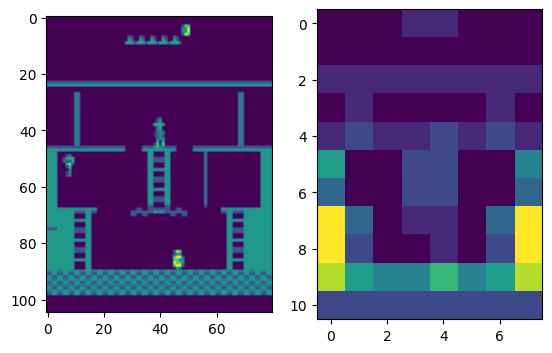

In [ ]:
plt.subplot(121)
plt.imshow(obs.numpy())
plt.subplot(122)
latent = to_latent(None, obs[None])[0]
plt.imshow(np.array(latent).reshape(11, 8))

In [ ]:
env = gym.make('MontezumaRevengeDeterministic-v4', render_mode='rgb_array')
env = gym.wrappers.ResizeObservation(env, (21*5, 16*5))
env = gym.wrappers.GrayScaleObservation(env)
env = GoExploreAtariWrapper(env)
snapshot, obs, reward, done, info = env.reset()
obs.shape

torch.Size([105, 80])

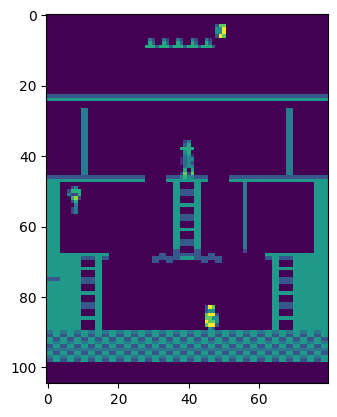

In [ ]:
plt.imshow(obs)

In [ ]:
snapshot, obs, reward, done, info = env.reset()
for i in range(10):
    snapshot, obs, reward, done, info = env.step(env.action_space.sample())
    # print(done)
    # if i%5==0:
        # plt.imshow(obs.numpy())
        # plt.show()
# plt.subplot(121)
# plt.imshow(obs.numpy())
# plt.subplot(122)
# plt.imshow(to_latent(None, obs))
# plt.show()

ValueError: too many values to unpack (expected 5)

In [ ]:
# for i in range(20):
#     snapshot, obs, reward, done, info = env.step(4)
#     print(info['lives'], env.unwrapped.ale.lives())

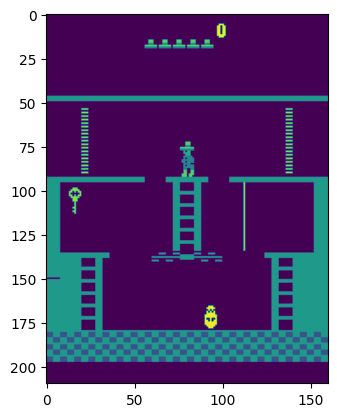

In [ ]:
plt.imshow(obs)

In [ ]:
np.random.seed(0)
snapshot, obs, reward, done, info = env.reset()
for i in range(10):
    snapshot, obs, reward, done, info = env.step(env.action_space.sample())

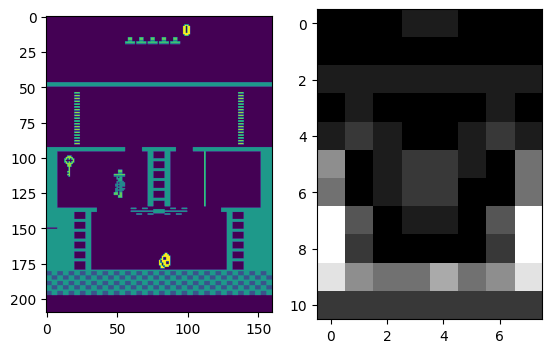

In [ ]:
plt.subplot(121)
plt.imshow(obs)
plt.subplot(122)
plt.imshow(to_latent(snapshot, obs), cmap='gray')

In [ ]:
class RandomExplorer(nn.Module):
    def __init__(self):
        super().__init__()
        
    def get_action_and_value(self, x, action=None):
        obs_ndim = len(env.observation_space.shape)
        bs = x.shape[:-obs_ndim]
        logits = torch.zeros(*bs, env.action_space.n)
        probs = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), 0.

In [ ]:
from collections import defaultdict
class Node():
    def __init__(self, parent, traj, snapshot, obs, latent):
        self.parent = parent
        self.children = []
        
        self.traj = traj
        self.traj_len = len(traj) + (self.parent.traj_len if self.parent else 0)

        self.snapshot = snapshot
        self.obs = obs
        self.latent = latent
        
    def get_full_trajectory(self):
        if self.parent is None:
            return self.traj
        return self.parent.get_full_trajectory() + self.traj

class Archive(list):
    def __init__(self, node_root):
        self.node_root = node_root
        self.cell2node = {}
        self.cell2n_seen = defaultdict(lambda : 0)
        
        self.add_node(node_root)
        
    def add_node(self, node):
        self.cell2node[node.latent] = node
        # self.append(node)
        if node.parent:
            node.parent.children.append(node)
            
    def add_if_better(self, node):
        cells = set(self.cell2node.keys())
        if node.latent in cells:
            node_old = self.cell2node[node.latent]
            # if len(node.get_full_trajectory())<len(node_old.get_full_trajectory()):
            if node.traj_len < node_old.traj_len:
                for child in node_old.children: # don't accumulate other nodes
                    child.parent = 'dead'
                
                self.add_node(node)
                return 1 # better
            return 2 # worse
        else:
            self.add_node(node)
            return 0 # novel
        
class GoExplore():
    def __init__(self, env, explorer, to_latent):
        self.env = env
        self.explorer = explorer
        self.to_latent = to_latent
        
        snapshot, obs, reward, done, info = self.env.reset()
        latent = self.to_latent(snapshot, obs)
        node_root = Node(None, [], snapshot, obs, latent)
        self.archive = Archive(node_root)
        
        self.trajs_good = []
        self.trajs_bad = []
        
    def select_nodes(self, n):
        cells = list(self.archive.cell2node.keys())
        n_seen = np.array([self.archive.cell2n_seen[cell] for cell in cells])
        p = 1./np.sqrt(n_seen+1)
        p = p/p.sum()
        cells_select = [cells[i] for i in np.random.choice(len(cells), size=n, p=p)]
        return [self.archive.cell2node[cell] for cell in cells_select]

    def explore_from(self, node_start, len_traj):
        traj = [] # list of tuples (snapshot, obs, action, log_prob, reward)
        snapshot, obs, reward, done, info = env.reset(node_start.snapshot)
        # latents = set()
        for i_trans in range(len_traj):
            # latent = self.to_latent(snapshot, obs)
            # latents.add(latent)
            with torch.no_grad():
                action, log_prob, _, _ = self.explorer.get_action_and_value(obs.to(device))
                action, log_prob = action.cpu(), log_prob.cpu()
            snapshot_next, obs_next, reward, done, info = self.env.step(action.item())
            traj.append((snapshot, obs, done, action, log_prob, reward))
            snapshot, obs = snapshot_next, obs_next
        # latent = self.to_latent(snapshot, obs)
        # latents.add(latent)
        # return Node(node_start, traj, snapshot, obs, latent), latents, done
        return traj
    
    def step_explore(self, n_trajs, len_traj):
        # nodes = []
        # dones = []
        nodes_start = self.select_nodes(n_trajs)
        trajs = [self.explore_from(node, len_traj) for node in nodes_start]
        # n_trajs, len_traj, (snapshot, obs, done, action, log_prob, reward)
        
        for node_start, traj in zip(nodes_start, trajs):
            snapshot, obs, done, action, log_prob, reward = traj[-1]
            is_novel = self.to_latent(snapshot, obs) not in self.archive.cell2node
            
            parent = node_start
            for i_trans, (snapshot, obs, done, action, log_prob, reward) in enumerate(traj):
                latent = self.to_latent(snapshot, obs)
                node_end = Node(parent, traj[i_trans: i_trans+1], snapshot, obs, latent)
                parent = node_end
                
                self.archive.cell2n_seen[latent] += 1
                self.archive.add_if_better(node_end)
            
            if is_novel:
                self.trajs_good.append(traj)
            else:
                self.trajs_bad.append(traj)

In [ ]:
explorer = RandomExplorer()
ge = GoExplore(env, explorer, to_latent=partial(to_latent, return_tuple=True))

In [ ]:
for i in tqdm(range(2000)):
    ge.step_explore(1, 10);

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
len(ge.trajs_good), len(ge.trajs_bad)

(295, 3705)

In [ ]:
len(ge.trajs_good), len(ge.trajs_bad)

(340, 5660)

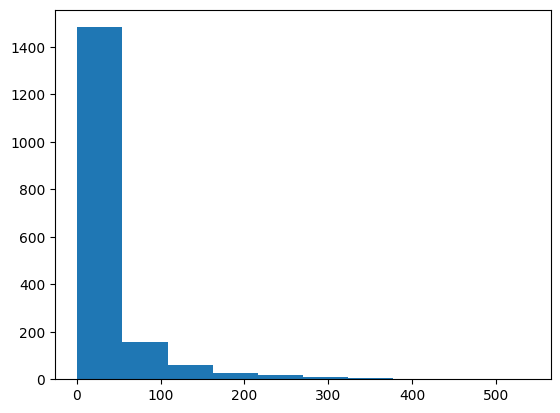

In [ ]:
n = np.array(list(ge.archive.cell2n_seen.values()))
plt.hist(n);plt.show()

In [ ]:
nodes = list(ge.archive.cell2node.values())
idx_sort, n_sort = np.argsort(n), np.sort(n)
nodes = [nodes[i] for i in idx_sort]

least encountered state


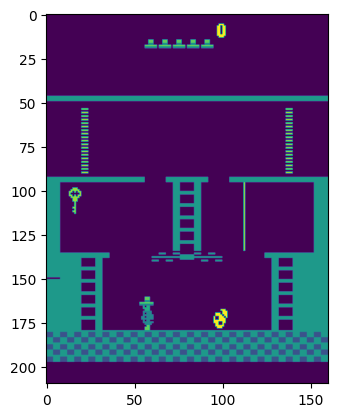

most encountered state


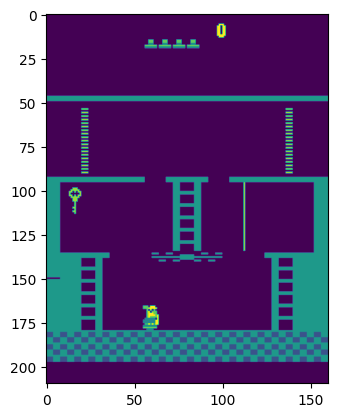

In [ ]:
print('least encountered state')
plt.imshow(nodes[0].traj[-1][1])
plt.show()
print('most encountered state')
plt.imshow(nodes[-1].traj[-1][1])
plt.show()

torch.Size([1766, 210, 160])
torch.Size([210, 160])


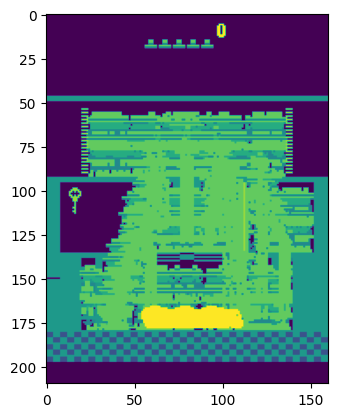

In [ ]:
o = torch.stack([node.obs for node in ge.archive.cell2node.values()])
print(o.shape)
o = o.max(dim=0).values
# o = o.mean(dim=-1).mean(dim=0)
print(o.shape)
plt.imshow(o.numpy())

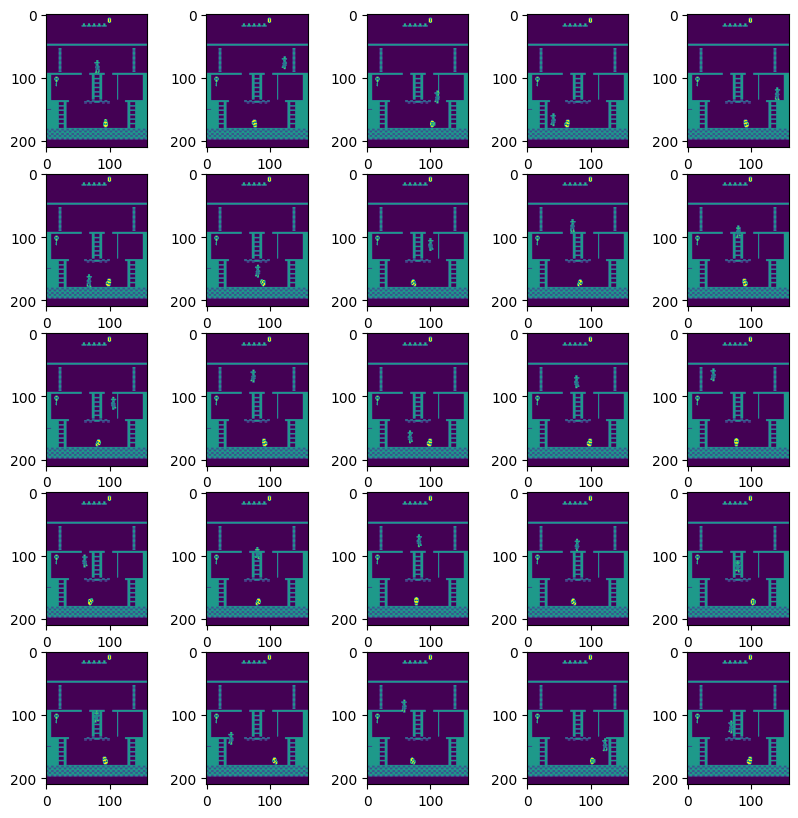

In [ ]:
x, y = 5, 5
fig, axs = plt.subplots(x, y, figsize=(10, 10))
nodes = np.random.choice(list(ge.archive.cell2node.values()), size=(x, y))

for i in range(x):
    for j in range(y):
        axs[i, j].imshow(nodes[i, j].obs.numpy())

In [ ]:
ge.trajs_good[0][0][3]

tensor(2)

In [ ]:
len(ge.archive.cell2node)

1766

In [ ]:
o = np.stack([node.obs for node in ge.archive.cell2node.values()])
print(o.shape)
# o = o[:, 97:120, 10:25]

(1766, 210, 160)


In [ ]:
# o.std(axis=0).max()

In [ ]:
# np.linalg.norm((o-o.mean(axis=0)).reshape(-1, 23*15*3), axis=-1).max()

In [ ]:
def tensor_stack(a):
    if isinstance(a, torch.Tensor):
        return a
    elif isinstance(a, list):
        return torch.stack([tensor_stack(i) for i in a])
    
# def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
def layer_init(layer, std=.01, bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer
    
class ImitationExplorer(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            layer_init(nn.Conv2d(1, 10, 8, stride=4)),
            nn.ReLU(),
            layer_init(nn.Conv2d(10, 10, 4, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(10, 10, 3, stride=2)),
            nn.ReLU(),
            layer_init(nn.Conv2d(10, 10, 3, stride=2)),
            nn.ReLU(),
            nn.Flatten(),
            layer_init(nn.Linear(10 * 5 * 3, 50)),
            nn.ReLU(),
        )
        self.actor = layer_init(nn.Linear(50, env.action_space.n), std=0.01)
        self.critic = layer_init(nn.Linear(50, 1), std=.01)
        
        self.opt = torch.optim.Adam(self.parameters(), lr=1e-2)
        self.losses_all = []

    def get_value(self, x):
        return self.critic(self.network(x))

    def get_action_and_value(self, x, action=None):
        x = x[..., None, :, :]
        hidden = self.network(x)
        logits = self.actor(hidden)
        probs = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(hidden), logits
    
    def update_policy(self, ge, n_steps, batch_size, viz=False):
        obs_good = tensor_stack([[trans[1] for trans in traj] for traj in ge.trajs_good])
        actions_good = tensor_stack([[trans[3] for trans in traj] for traj in ge.trajs_good])
        obs_good = obs_good.reshape(-1, *obs_good.shape[2:])
        actions_good = actions_good.reshape(-1)

        obs_bad = tensor_stack([[trans[1] for trans in traj] for traj in ge.trajs_bad])
        actions_bad = tensor_stack([[trans[3] for trans in traj] for traj in ge.trajs_bad])
        obs_bad = obs_bad.reshape(-1, *obs_bad.shape[2:])
        actions_bad = actions_bad.reshape(-1)
        
        losses = []
        # plt.subplot(121)
        # plt.hist(actions_good.flatten().numpy())
        # plt.subplot(122)
        # plt.hist(actions_bad.flatten().numpy())
        # plt.show()
        
        loss_fn = nn.CrossEntropyLoss(reduction='none')
        pbar = tqdm(range(n_steps))
        for i_batch in pbar:
            idx_good = torch.randperm(len(obs_good))[:batch_size//2]
            idx_bad = torch.randperm(len(obs_bad))[:batch_size//2]
            batch_obs_good = obs_good[idx_good].to(device)
            batch_obs_bad = obs_bad[idx_bad].to(device)
            batch_actions_good = actions_good[idx_good].to(device)
            batch_actions_bad = actions_bad[idx_bad].to(device)
            
            _, log_probs_good, entropy, _, logits_good = self.get_action_and_value(batch_obs_good, batch_actions_good)
            _, log_probs_bad, entropy, _, logits_bad = self.get_action_and_value(batch_obs_bad, batch_actions_bad)
            # loss_good = 
            
            # b = log_probs_good
            # print(a.shape, b.shape)
            # print(a.mean().item(), b.mean().item())
            # print(len(log_probs_good), len(log_probs_bad))

            # loss = log_probs_bad.mean()-log_probs_good.mean()
            # loss = loss_fn(logits_good, batch_actions_good.long()).mean() - loss_fn(logits_bad, batch_actions_bad.long()).mean()
            loss = loss_fn(logits_good, batch_actions_good.long()).mean()
            # loss = -log_probs_bad.mean()+log_probs_good.mean()
            # loss = log_probs_bad.mean()

            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
            # losses.append(loss.item())
            # losses.append(log_probs_bad.mean().item())
            # losses.append((loss.item(), log_probs_bad.mean().item(), log_probs_good.mean().item()))
            losses.append(loss.item())
            pbar.set_postfix(loss=loss.item(), good=log_probs_good.mean().item(), bad=log_probs_bad.mean().item())

        # batch_actions = torch.cat([batch_actions_good, batch_actions_bad], dim=0)
        # log_probs = torch.cat([log_probs_good, log_probs_bad], dim=0)

        # self.losses_all.extend(losses)
        if viz:
            losses = np.array(losses)
            print(losses.shape)
            plt.plot(losses)
            plt.show()
            # for i in range(4):
                # print(f'Action {i}')
                # print(log_probs[batch_actions==i].mean().item())


In [ ]:
net = ImitationExplorer(env).to(device)
# net.get_action_and_value(obs[None])
print('num params: ', np.sum([p.numel() for p in net.parameters()]))

num params:  12599


(1766, 210, 160)
torch.Size([1766])


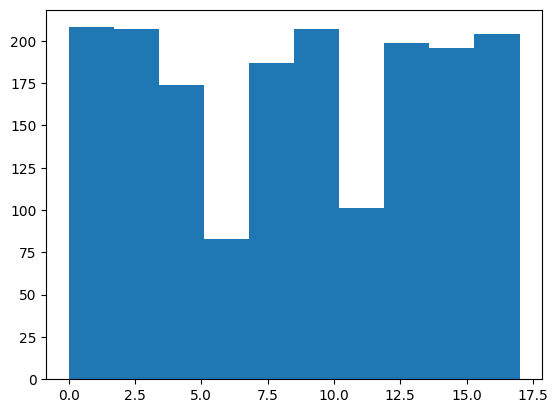

In [ ]:
print(o.shape)
action, _, _, _, _ = net.get_action_and_value(torch.as_tensor(o).to(device))
print(action.shape)
plt.hist(action.detach().cpu().numpy());

  0%|          | 0/500 [00:00<?, ?it/s]

(500,)


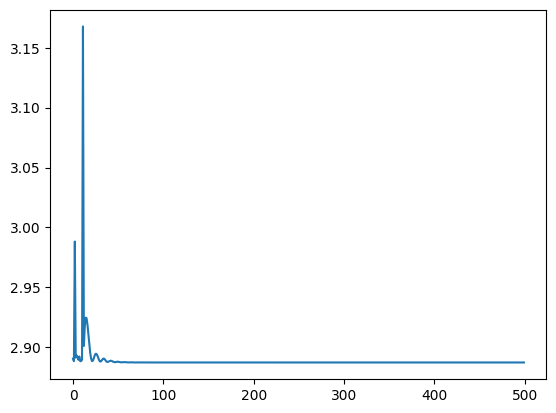

In [ ]:
net.update_policy(ge, 500, 10000, viz=True)

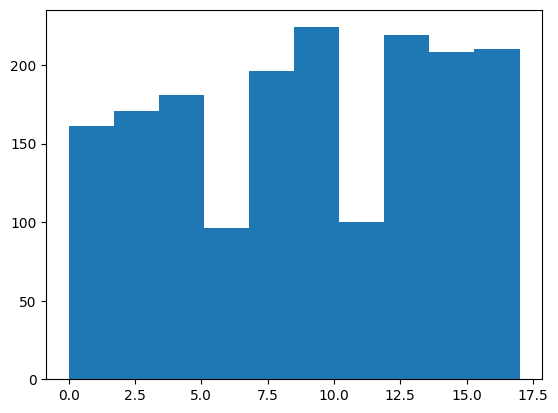

In [ ]:
action, _, _, _, _ = net.get_action_and_value(torch.as_tensor(o).to(device))
plt.hist(action.detach().cpu().numpy());

In [ ]:
env.unwrapped.get_action_meanings()[10]

'UPFIRE'

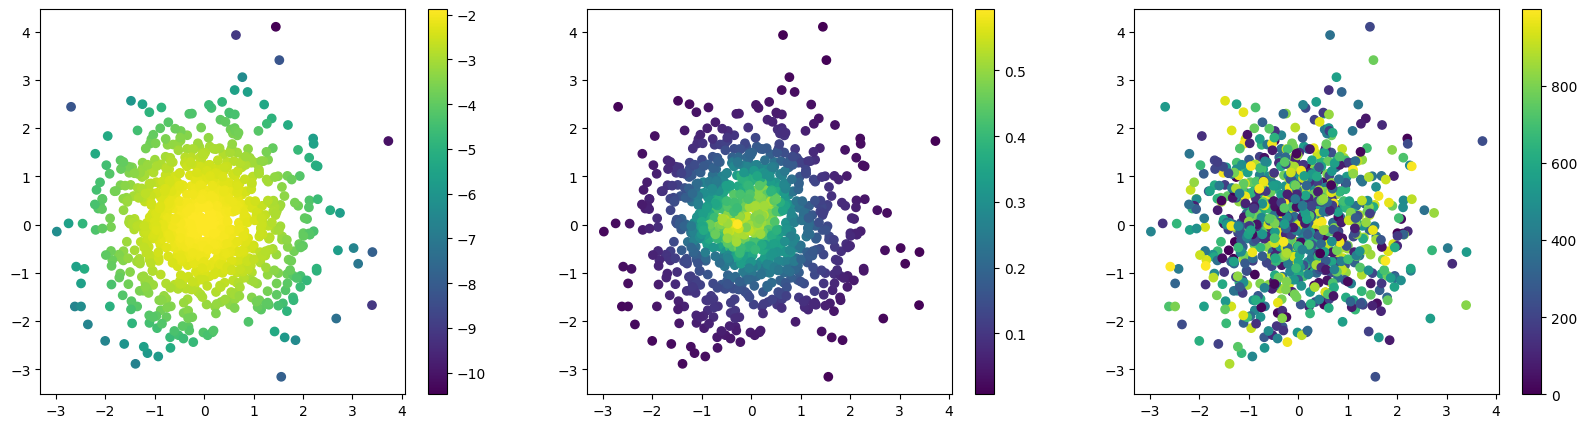

In [ ]:
import sklearn.mixture

def gaussian_density(q):
    gm = sklearn.mixture.GaussianMixture(n_components=1)
    gm = gm.fit(x.numpy())
    return torch.from_numpy(gm.score_samples(q.numpy()))

def other_density(q):
    n, d = x.shape
    k = int(2.*(n**(1./d)))
    dist = (q[:, None]-x[None, :]).norm(dim=-1)
    dist = dist.sort(dim=-1).values[:, k]
    idist = dist**-d
    density = k/n*idist
    return density
def other_density2(q, p=.1):
    density = other_density(q)
    ranks = density.argsort()
    return ranks
    # density = p*(1.-p)**ranks
    # density = density/density.sum()
    # return density

torch.manual_seed(0)
x = torch.randn(1000, 2)


plt.figure(figsize=(20, 5))
plt.subplot(131)
d = gaussian_density(x)
plt.scatter(*x.numpy().T, c=d.numpy())
plt.colorbar()
plt.subplot(132)
d = other_density(x)
plt.scatter(*x.numpy().T, c=d.numpy())
plt.colorbar()
plt.subplot(133)
d = other_density2(x, p=0.001)
plt.scatter(*x.numpy().T, c=d.numpy())
plt.colorbar()

plt.show()

In [ ]:
import gym
import nle

In [ ]:
env = gym.make("NetHackScore-v0")
env.reset()  # each reset generates a new dungeon
env.step(1)  # move agent '@' north
env.render()


It's a wall.                                                                    
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           